Felipe Bartelt de Assis Pessoa - 2016026841

#  Multilayer Perceptron (MLP)

Para se avaliar o desempenho de MLPs ao se alterar o número de neurônios na camada escondida e suas respectivas funções de ativação, utilizou-se os métodos de MLP intrínsecos ao `scikit-learn` para aproximar dois *datasets*, um de regressão e outro de classificação.

Para ambos os conjuntos de dados, obteve-se os erros médios em $10$ iterações, variando-se o número de neurônios da camada intermediária entre $1$ e $2\cdot h$, sendo $h$ o número de variáveis do conjunto. Essas iterações foram feitas para cada uma das funções de ativação disponíveis nos modelos do `sklearn`: identidade, sigmoid, tanh e ReLU.

## Boston Housing

O primeiro *dataset* a ser testado é o [Boston Housing](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/), que é fornecido diretamente pela biblioteca `sklearn`. Fez-se a normalização *standardization* sobre as amostras e dividiu-se o conjunto em conjunto de treino e teste, sendo o conjunto de teste $30\%$ do total.

In [60]:
from sklearn.datasets import load_boston
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


Utilizou-se o método LBFGS como otimizador de custo do MLP, tomando máximo de iterações $=2000$ e tolerância de erro $0.01$. Definiu-se ainda um parâmetro de regularização igual a $15$, de forma a se obter resultados melhores nos dados de teste, evitando o *overfitting*. Esse valor de regularização foi definido por meio de alguns testes e análise de erro.

In [179]:
%%capture --no-stdout
X, y = load_boston(return_X_y=True)
standardize = StandardScaler()
X = standardize.fit_transform(X)
act_funs = ['identity', 'logistic', 'tanh', 'relu']
dim_list = np.arange(1,27)
reg_par = 15
fig = make_subplots(rows=2, cols=2, subplot_titles=tuple(k+' activation' for k in act_funs))
mses, stds = [], []

for i, act_fun in enumerate(act_funs):
    mse_train_list, mse_test_list = [], []

    for hidden_dim in dim_list:
        mlp_reg = MLPRegressor(hidden_layer_sizes=hidden_dim,
                               activation=act_fun, solver='lbfgs', 
                               alpha=reg_par, max_iter=2000, tol=0.01);
        mse_train, mse_test = [], []
        
        for _ in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
            mlp_reg.fit(X_train, y_train);
            yhat_train = mlp_reg.predict(X_train)
            yhat_test = mlp_reg.predict(X_test)
            mse_train.append(mean_squared_error(yhat_train, y_train))
            mse_test.append(mean_squared_error(yhat_test, y_test))

        mse_train_stat = (np.mean(mse_train), np.std(mse_train))
        mse_test_stat = (np.mean(mse_test), np.std(mse_test))
        mse_train_list.append(mse_train_stat)  
        mse_test_list.append(mse_test_stat)

    mean_train, std_train = list(zip(*mse_train_list))
    mean_test, std_test = list(zip(*mse_test_list))
    mses.append(np.array(mean_test))
    stds.append(np.array(std_test))
    fig.add_scatter(x=dim_list, y=mean_train, error_y= {'type':'data', 
                    'array':std_train, 'thickness':1}, name='train set', 
                    row = 1*(i>1)+1, col=2**(i%2), line={'color':'blue'},
                    showlegend=(i==0))
    fig.add_scatter(x=dim_list, y=mean_test, error_y = {'type':'data', 
                    'array':std_test, 'thickness':1}, name='test set', 
                    row = 1*(i>1)+1, col=2**(i%2), line={'color':'red'},
                    showlegend=(i==0))
    fig.update_yaxes(title_text="MSE", row= 1*(i>1)+1, col=2**(i%2))
    fig.update_xaxes(title_text="Hidden Layer Dimension", row= 1*(i>1)+1, col=2**(i%2))

Os erros quadráticos médios e seus desvios padrão, dentro das $10$ iterações, são mostrados na figura abaixo:

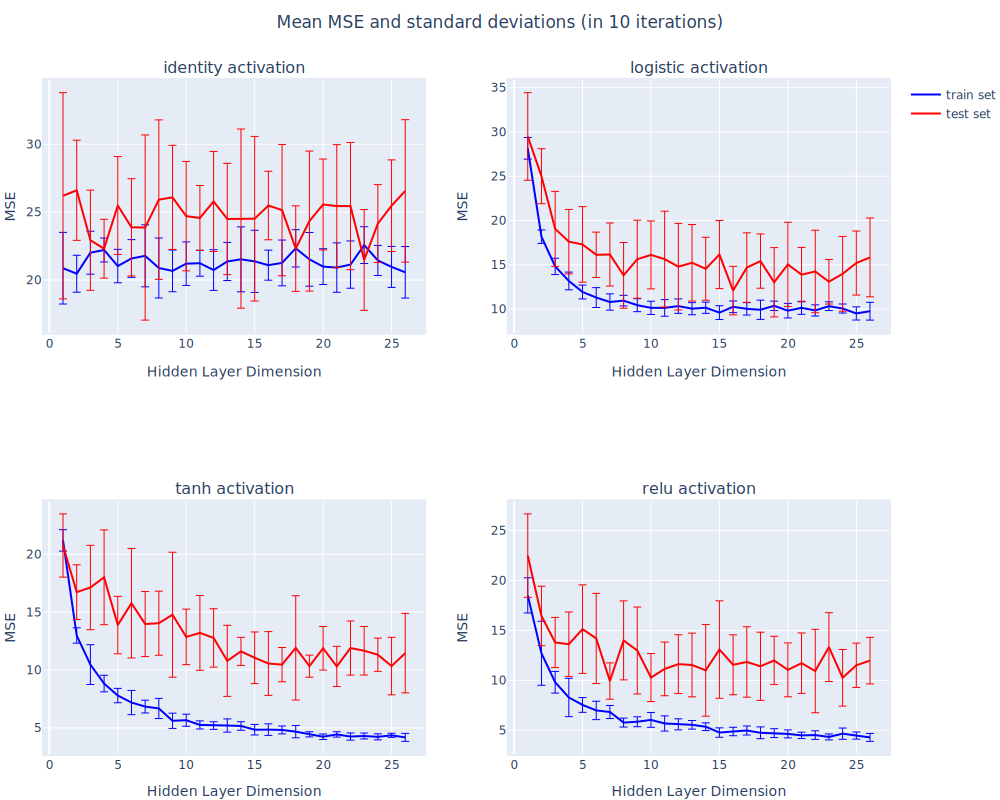

In [180]:
fig.update_layout(height=800, width=1000, title={'text':"Mean MSE and standard deviations (in 10 iterations)", 'x':0.5, 'y':0.98}, margin = {'b':10, 't':80, 'r':2, 'l':2, 'pad':2})
fig.show(renderer='svg',height=800, width=1000)

Ainda, mostra-se os menores MSE obtidos por cada função de ativação e o número de neurônios necessários para tal resultado:

In [187]:
min_idx = np.argmin(mses, axis=1)
print('Menores MSEs médios para cada função de ativação:')
print('função\t\t\tn° neurônios\t\t\tMSE')
print('-'*68)
for i, idx in enumerate(min_idx):
    print(f'{act_funs[i]+"    "*(i>1)}\t\t   {idx+1}\t\t\t {mses[i][idx]}')

Menores MSEs médios para cada função de ativação:
função			n° neurônios			MSE
--------------------------------------------------------------------
identity		   23			 21.47780861103719
logistic		   16			 12.086023597411685
tanh    		   21			 10.312929511015502
relu    		   7			 9.931570157176079


Por meio dos resultados gráficos e melhores MSE obtidos, pode-se dizer que a função de ativação identidade nos neurônios da camada intermediária não é uma boa escolha para essa aplicação. Obteve-se menor erro ao se utilizar a função $\tanh(\cdot)$, com $21$ neurônios na camada intermediária. A função de ativação logística sigmoidal unipolar obteve menor MSE $\approx12.1$, com $16$ neurônios e, dessa forma, pode ser mais vantajoso seu uso ao da tangente hiperbólica desde que se consiga reduzir ainda mais o MSE nos dados de teste. Por último, observa-se que o comportamento da ReLU foi o melhor de todos, obtendo o menor MSE geral $9.93$ com apenas $7$ neurônios na camada intermediária, que corresponde à, aproxidamente, metade do número de variáveis do conjunto.

## Statlog (Heart)

O segundo conjunto de testes utilizado foi o [Statlog(Heart)](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/), baixado diretamenta da UCI. Novamente os dados foram normalizados por meio de *standardization* e separados em conjunto de treino e teste, com proporção idêntica à anterior.


Utilizou-se o método LBFGS como otimizador de custo do MLP, tomando máximo de iterações $=2000$ e tolerância de erro $0.01$. Definiu-se ainda um parâmetro de regularização igual a $3$, de forma a se obter resultados melhores nos dados de teste, evitando o *overfitting*. Esse valor de regularização foi definido por meio de alguns testes e análise de erro.

In [193]:
data = np.loadtxt('heart.dat')
X = np.copy(data[:, 0:-1])
y = np.copy(data[:, -1])
y[y==2]=0

In [224]:
%%capture --no-stdout

X = standardize.fit_transform(X)
dim_list = np.arange(1,27)
reg_par = 3
fig = make_subplots(rows=2, cols=2, subplot_titles=tuple(k+' activation' for k in act_funs))
mses, stds = [], []

for i, act_fun in enumerate(act_funs):
    acc_train_list, acc_test_list = [], []

    for hidden_dim in dim_list:
        mlp_clf = MLPClassifier(hidden_layer_sizes=hidden_dim, 
                                activation=act_fun, solver='lbfgs', 
                                alpha=reg_par, max_iter=2000, tol=0.01);
        acc_train, acc_test = [], []
        
        for _ in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
            mlp_clf.fit(X_train, y_train);
            acc_train.append(mlp_clf.score(X_train, y_train))
            acc_test.append(mlp_clf.score(X_test, y_test))

        acc_train_stat = (np.mean(acc_train), np.std(acc_train))
        acc_test_stat = (np.mean(acc_test), np.std(acc_test))
        acc_train_list.append(acc_train_stat)  
        acc_test_list.append(acc_test_stat)

    mean_train, std_train = list(zip(*acc_train_list))
    mean_test, std_test = list(zip(*acc_test_list))
    mses.append(np.array(mean_test))
    stds.append(np.array(std_test))
    fig.add_scatter(x=dim_list, y=mean_train, error_y= {'type':'data', 
                    'array':std_train, 'thickness':1}, name='train set',
                    row = 1*(i>1)+1, col=2**(i%2), line={'color':'blue'},
                    showlegend=(i==0))
    fig.add_scatter(x=dim_list, y=mean_test, error_y = {'type':'data',
                    'array':std_test, 'thickness':1},  name='test set', 
                    row = 1*(i>1)+1, col=2**(i%2), line={'color':'red'},
                    showlegend=(i==0))
    fig.update_yaxes(title_text="Accuracy", row= 1*(i>1)+1, col=2**(i%2))
    fig.update_xaxes(title_text="Hidden Layer Dimension", row= 1*(i>1)+1, col=2**(i%2))

As acurácias médias e seus desvios padrão, dentro das $10$ iterações, são mostrados na figura abaixo:

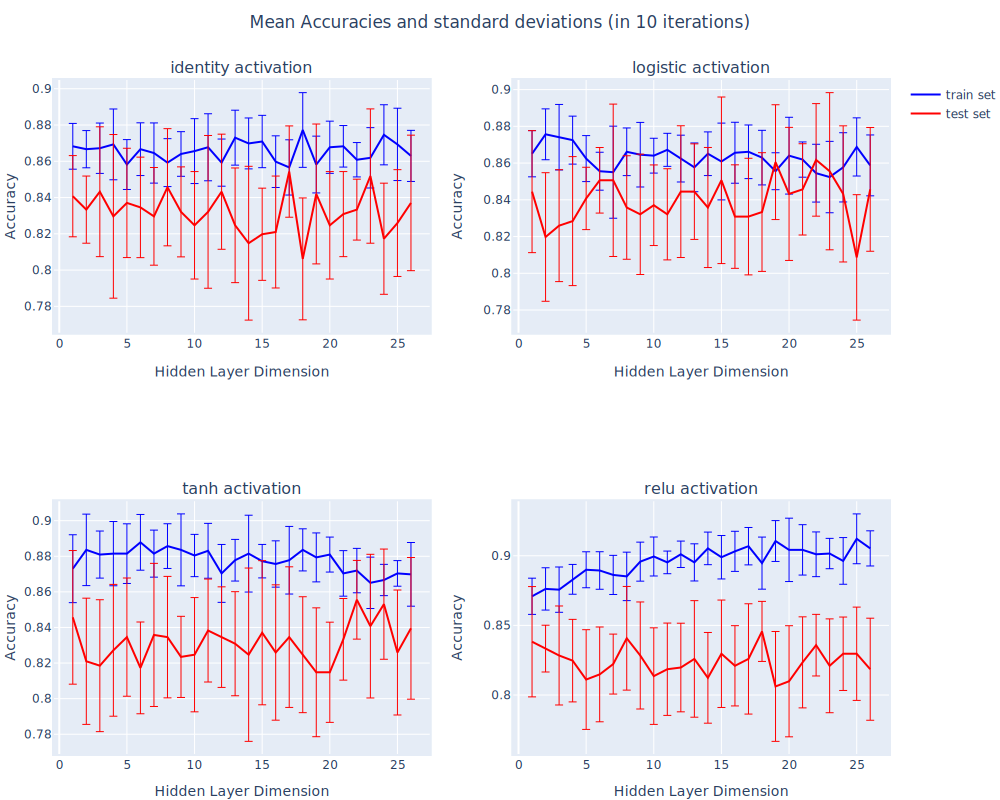

In [225]:
fig.update_layout(height=800, width=1000, title={'text':"Mean Accuracies and standard deviations (in 10 iterations)", 'x':0.5, 'y':0.98}, margin = {'b':10, 't':80, 'r':2, 'l':2, 'pad':2})
fig.show(renderer='svg',height=800, width=1000)

Ainda, mostra-se as melhores acurácias médias obtidas por cada função de ativação e o número respectivo de neurônios necessários para tal resultado.

In [226]:
min_idx = np.argmax(mses, axis=1)
print('Maiores acurácias médios para cada função de ativação:')
print('função\t\t\tn° neurônios\t\t\tAcurácia')
print('-'*68)
for i, idx in enumerate(min_idx):
    print(f'{act_funs[i]+"    "*(i>1)}\t\t   {idx+1}\t\t\t {mses[i][idx]}')

Maiores acurácias médios para cada função de ativação:
função			n° neurônios			Acurácia
--------------------------------------------------------------------
identity		   17			 0.8543209876543211
logistic		   22			 0.8617283950617283
tanh    		   22			 0.8555555555555555
relu    		   18			 0.845679012345679


Por meio dos resultados obtidos, pode-se notar que a função de ativação identidade obteve comportamento muito melhor para o problema de classificação do que o problema de regressão, obtendo neste conjunto de dados, melhor acurácia média de $85.4\%$, com $17$ neurônios na camada intermediária. As funções de ativação sigmoidais unipolar e tangente hiperbólica obtiveram melhores acurácias médias para o mesmo número de neurônios, $22$, porém a função logística obteve uma acurácia melhor, de $86.2\%$, em comparação com a acurácia obtida por tanh: $85.6\%$. Por último, a função de ativação ReLU obteve a pior das acurácias, de valor $84.6\%$ com $18$ neurônios.

Em suma, nota-se a importância de um conjunto de validação cruzada para que se defina o melhor número de neurônios de uma rede, seu parâmetro de regularização e função de ativação das camadas.